In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
filename="/content/drive/My Drive/HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")


done


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
data_pd = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [ ]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [ ]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [ ]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [ ]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [ ]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [ ]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train


In [ ]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
5106,HAM_0004931,ISIC_0026428,nv,follow_up,50.0,male,lower extremity,no
6623,HAM_0001984,ISIC_0025092,nv,follow_up,50.0,male,trunk,no
5908,HAM_0001664,ISIC_0025217,nv,follow_up,50.0,male,back,no
4156,HAM_0005306,ISIC_0027056,nv,follow_up,60.0,male,back,no
4579,HAM_0002478,ISIC_0031787,nv,follow_up,60.0,female,unknown,no


In [ ]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [ ]:
len(test_list)

828

In [ ]:
len(train_list)

9187

In [ ]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [ ]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [ ]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('HAM10000', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [ ]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('HAM10000', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = 'HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(299, 299),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [ ]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'

In [ ]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [ ]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=10,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=1,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [ ]:

irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output


225214464/225209952 [==============================] - 2s 0us/step


In [ ]:


conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


In [ ]:

output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = 'saved_model.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [ ]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    epochs=150,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df),callbacks=[checkpoint,Earlystop],class_weight=class_weights)

In [ ]:
from tensorflow.keras import models
model.load_weights("saved_model.hdf5")

In [ ]:
predictions = model.predict(test_batches, steps=len(test_df), verbose=1)

828/828 [==============================] - 24s 29ms/step


In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.83      0.83      0.83        23
         bcc       0.80      0.92      0.86        26
         bkl       0.78      0.61      0.68        66
          df       0.75      0.50      0.60         6
         mel       0.47      0.59      0.52        34
          nv       0.96      0.97      0.97       663
        vasc       1.00      1.00      1.00        10

    accuracy                           0.92       828
   macro avg       0.80      0.77      0.78       828
weighted avg       0.92      0.92      0.92       828



In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9179089183673989
Recall: 0.9154589371980676
Accuracy: 0.9154589371980676
weighted Roc score: 0.9796435330172768


In [ ]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Precision: 0.7982908145301982
Recall: 0.7731122245188741
Accuracy: 0.9154589371980676
Macro Roc score: 0.9800820580552447


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9154589371980676
Recall: 0.9154589371980676
Accuracy: 0.9154589371980676
Micro Roc score: 0.9950861844305974


In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9929786659465298
The ROC AUC score of bcc is: 0.9977939765969691
The ROC AUC score of bkl is: 0.9738527002306531
The ROC AUC score of df is: 0.9525547445255476
The ROC AUC score of mel is: 0.9635871981034226
The ROC AUC score of nv is: 0.9798071209835915
The ROC AUC score of vasc is: 1.0


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

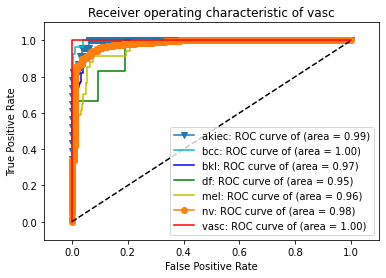

In [ ]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

**Grad-Cam**

In [ ]:


# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=1,
                                           shuffle=False)

Found 828 images belonging to 7 classes.


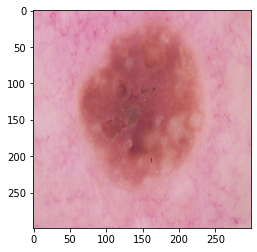

In [ ]:

img_size = (299, 299)

img_array,_=next(test_batches)
last_conv_layer_name = "conv2d_195"

plt.imshow((img_array[0]+1)/2)


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
preds = model.predict(img_array)
np.argmax(preds)

2

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

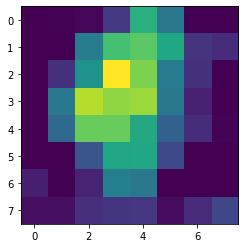

In [ ]:
plt.imshow(heatmap)

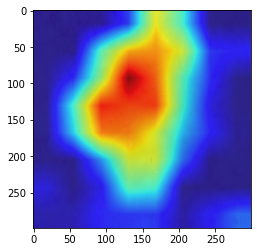

In [ ]:
def save_and_display_gradcam(img_array, heatmap, alpha=0.4):
    # Load the original image
    
    img = (img_array[0] + 1)/2

    # Rescale heatmap to a range 0-255
    #heatmap = np.uint8(255 * heatmap)
    plt.imshow(img,alpha=1.0)
    plt.imshow(cv2.resize(heatmap,(299,299)),cmap='jet',alpha=0.8)
    plt.show()

    # Display Grad CAM
 


save_and_display_gradcam(img_array, heatmap)


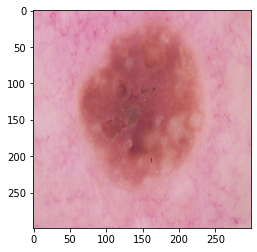

In [ ]:
plt.imshow((img_array[0]+1)/2)